In [35]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [36]:
DATA_DIR = 'Final_Project/Dataset/tiff/'

# x_train_dir = os.path.join(DATA_DIR, 'train')
# y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_train_dir = os.getcwd()+"/Dataset/tiff/train"
y_train_dir = os.getcwd()+"/Dataset/tiff/train_labels"

# x_valid_dir = os.path.join(DATA_DIR, 'val')
# y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_valid_dir = os.getcwd()+"/Dataset/tiff/val"
y_valid_dir = os.getcwd()+"/Dataset/tiff/val_labels"

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'test_labels')

x_test_dir = os.getcwd()+"/Dataset/tiff/test"
y_test_dir = os.getcwd()+"/Dataset/tiff/test_labels"

In [37]:
# print(os.getcwd()+"/Dataset/tiff/1 +\n")
print(os.getcwd()+"/test/")
# os.path.exists(os.getcwd()+"/Dataset/tiff/")
print(x_train_dir)

/Users/gx/Desktop/AI_ML_DL/Final_Project/test/
/Users/gx/Desktop/AI_ML_DL/Final_Project/Dataset/tiff/train


In [38]:
class_dict = pd.read_csv("Dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [39]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'road']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [40]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [41]:
class RoadsDataset(torch.utils.data.Dataset):

    """Massachusetts Roads Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

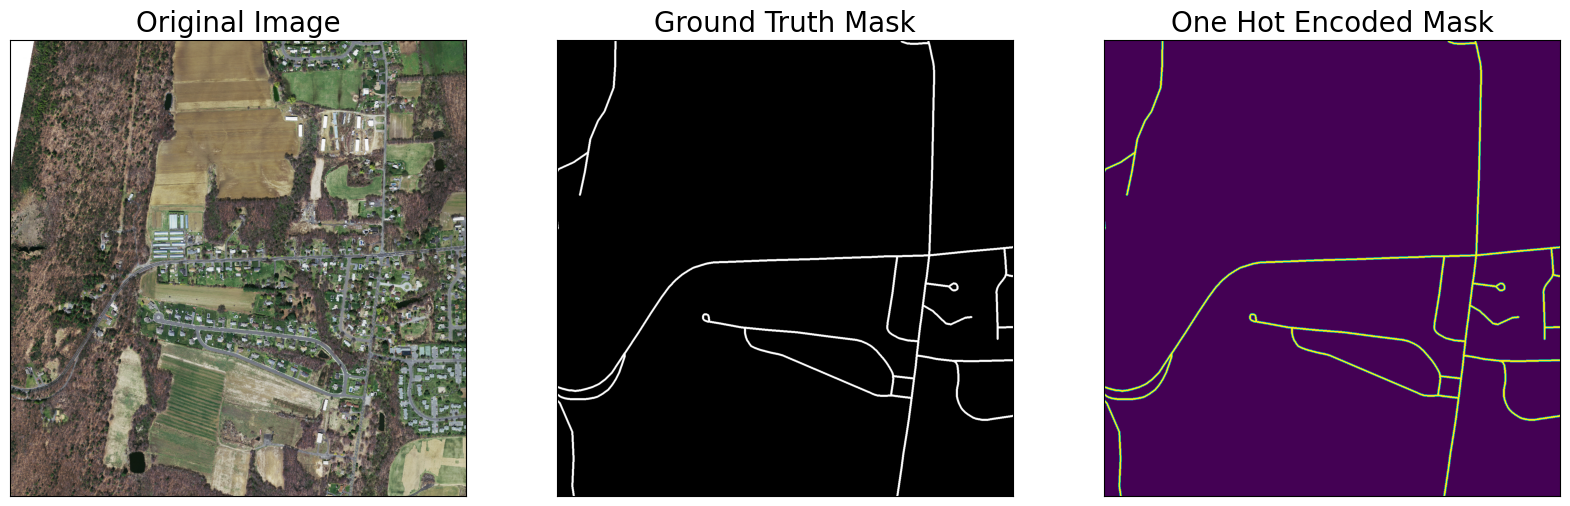

In [42]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [43]:
print(os.getcwd())

/Users/gx/Desktop/AI_ML_DL/Final_Project


In [44]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

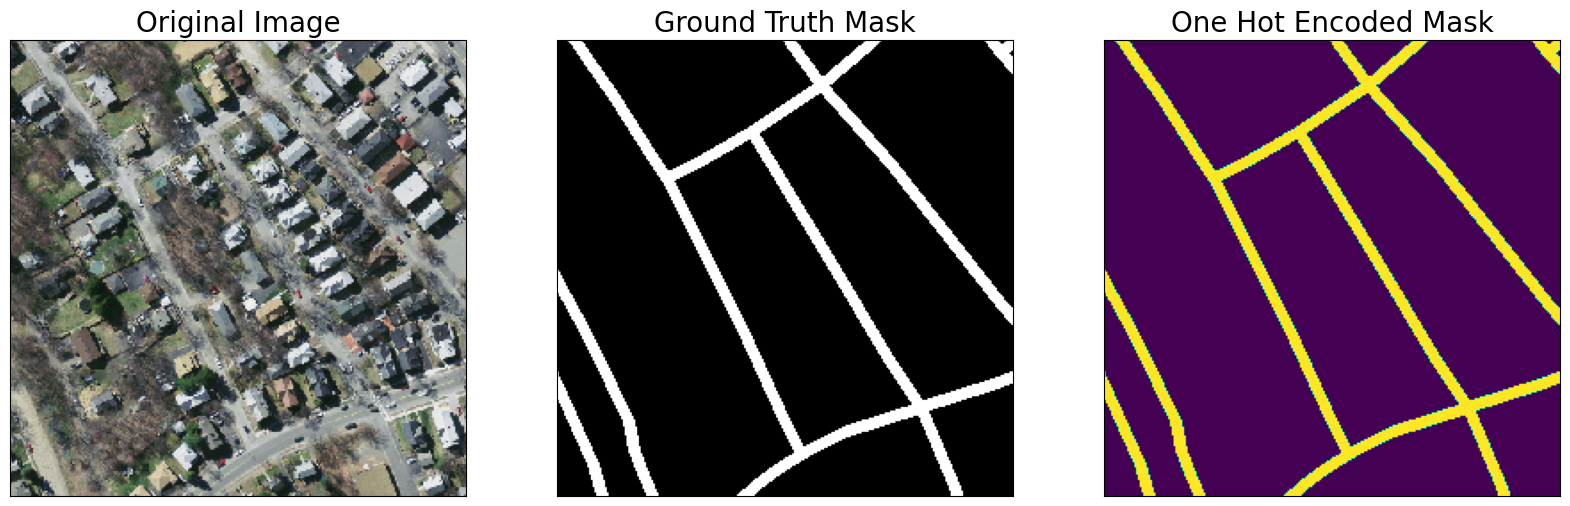

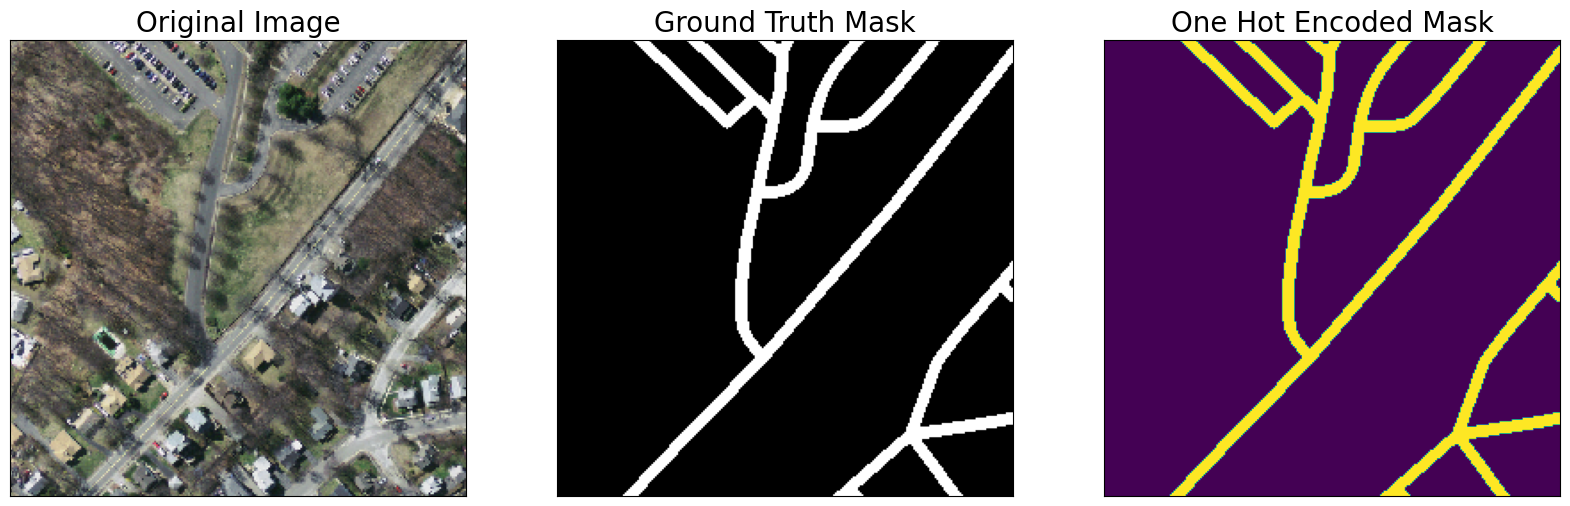

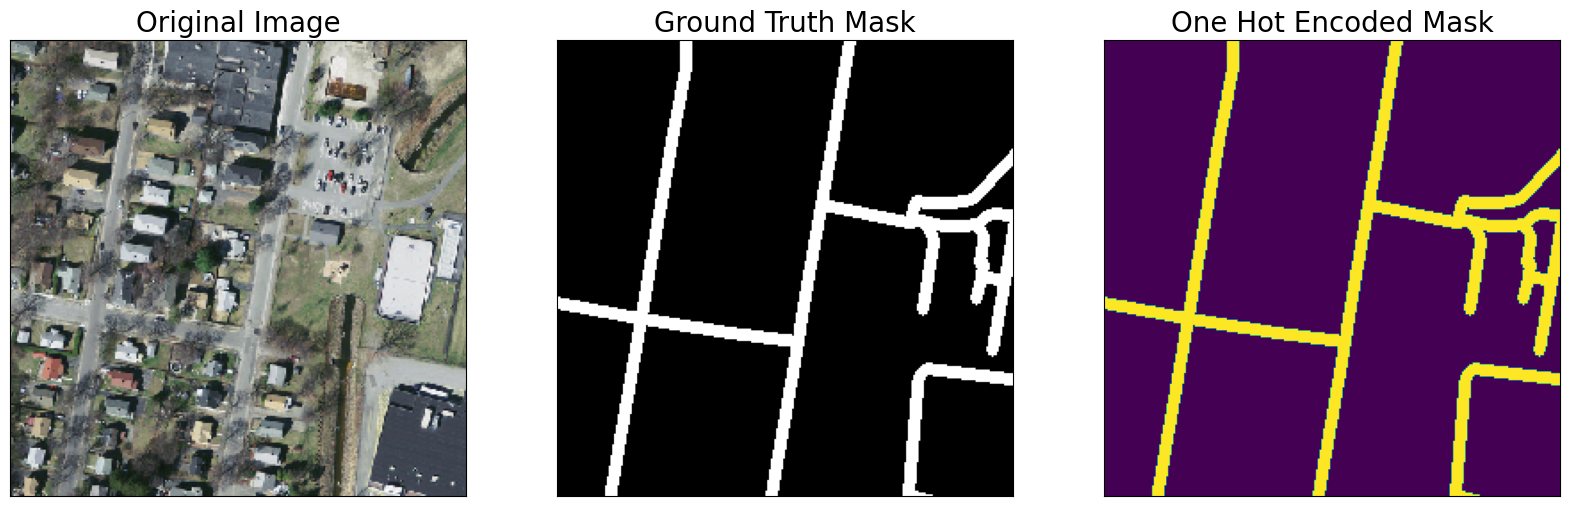

In [45]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [46]:
!pip install segmentation-models-pytorch


Defaulting to user installation because normal site-packages is not writeable


In [47]:
# Encoder specifications
ENCODER = 'resnet50'  # or 'resnet101' for more powerful features
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes  # your list of classes
ACTIVATION = 'softmax'  

# DeepLabV3 model initialization
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

# Preprocessing function based on the encoder
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [48]:
# Get train and val dataset instances
train_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [49]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 5

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
    model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [50]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [51]:
%%time

if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
train:   0%|          | 0/70 [00:00<?, ?it/s]

train:   1%|▏         | 1/70 [00:15<18:15, 15.88s/it, dice_loss - 0.5701, iou_score - 0.1989]


KeyboardInterrupt: 

In [52]:
# load best saved model checkpoint from the current run
if os.path.exists('best_model.pth'):
    best_model = torch.load('best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# # load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth'):
#     best_model = torch.load('../input/unet-resnet50-frontend-road-segmentation-pytorch/best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


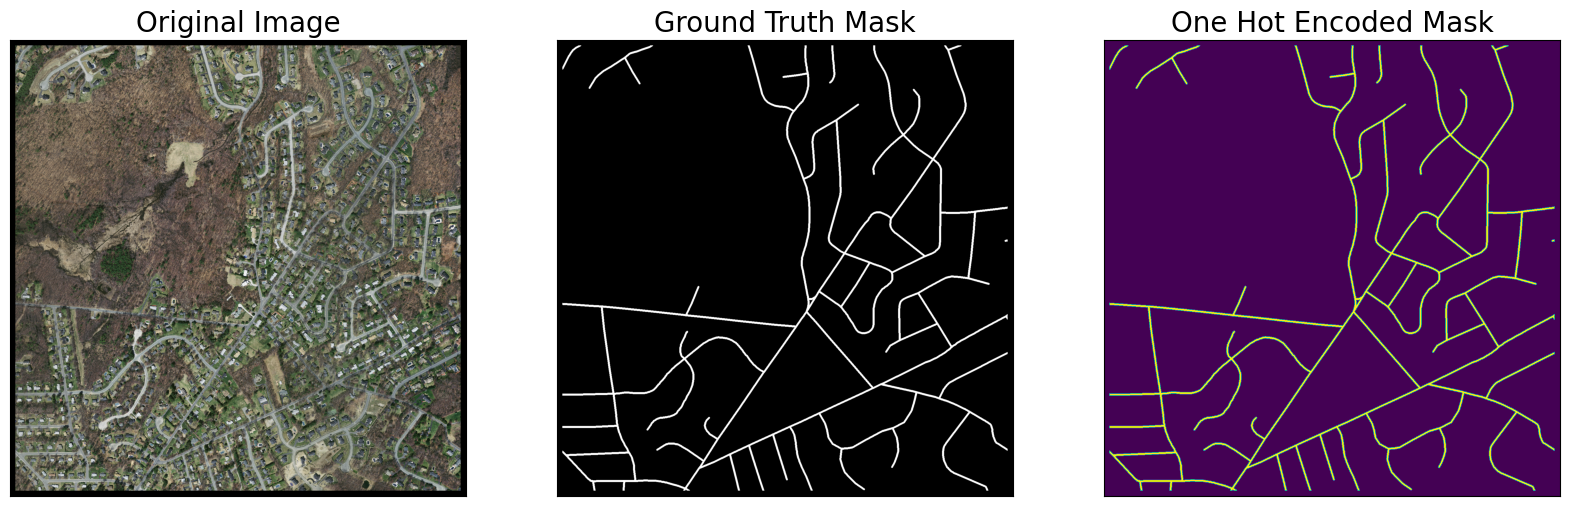

In [53]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

# Notice the images / masks are 1536*1536 because of 18px padding on all sides. 
# This is to ensure the input image dimensions to UNet model are a multiple of 2 (to account for pooling & transpose conv. operations).

In [54]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [55]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [56]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to road
    pred_road_heatmap = pred_mask[:,:,select_classes.index('road')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_road_heatmap = pred_road_heatmap
    )

KeyboardInterrupt: 

In [57]:
def predict_and_visualize_from_path(img_path, model, device, select_classes, class_rgb_values, preprocessing_fn=None, expected_dim=32):
    """
    Predicts the segmentation mask for an image loaded from a given path and visualizes the results.

    Args:
    - img_path (str): The path to the input image for prediction.
    - model (torch.nn.Module): The trained PyTorch model for segmentation.
    - device (torch.device): The device to run the model on.
    - select_classes (list): List of selected class names for prediction.
    - class_rgb_values (list): RGB values of the selected classes.
    - preprocessing_fn (function, optional): Preprocessing function to apply to the image before prediction.
    - expected_dim (int): The dimension that the height and width of the image should be divisible by.

    Returns:
    - pred_mask (numpy.ndarray): Predicted mask for the input image.
    - pred_road_heatmap (numpy.ndarray): Heatmap for the road predictions.
    """
    # Load the image
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # Ensure the image dimensions are divisible by expected_dim
    height, width, _ = img.shape
    pad_height = (expected_dim - height % expected_dim) % expected_dim
    pad_width = (expected_dim - width % expected_dim) % expected_dim
    padded_img = cv2.copyMakeBorder(img, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=[0,0,0])

    # Preprocess the image
    if preprocessing_fn is not None:
        processed = preprocessing_fn(image=padded_img)
        img_processed = processed['image']
    else:
        img_processed = padded_img

    # Convert to tensor and add batch dimension
    img_tensor = torch.from_numpy(img_processed).to(device).unsqueeze(0)

    # Predict the mask
    with torch.no_grad():
        pred_mask = model(img_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    # Convert prediction from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask, (1, 2, 0))

    # Get prediction channel corresponding to road
    pred_road_heatmap = pred_mask[:, :, select_classes.index('road')]

    # Apply reverse one-hot encoding and color coding
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values)

    # Crop the prediction to original image size
    pred_mask = pred_mask[:height, :width]
    pred_road_heatmap = pred_road_heatmap[:height, :width]

    # Visualize the results
    visualize(
        original_image=img,
        predicted_mask=pred_mask,
        predicted_road_heatmap=pred_road_heatmap
    )

    return pred_mask, pred_road_heatmap


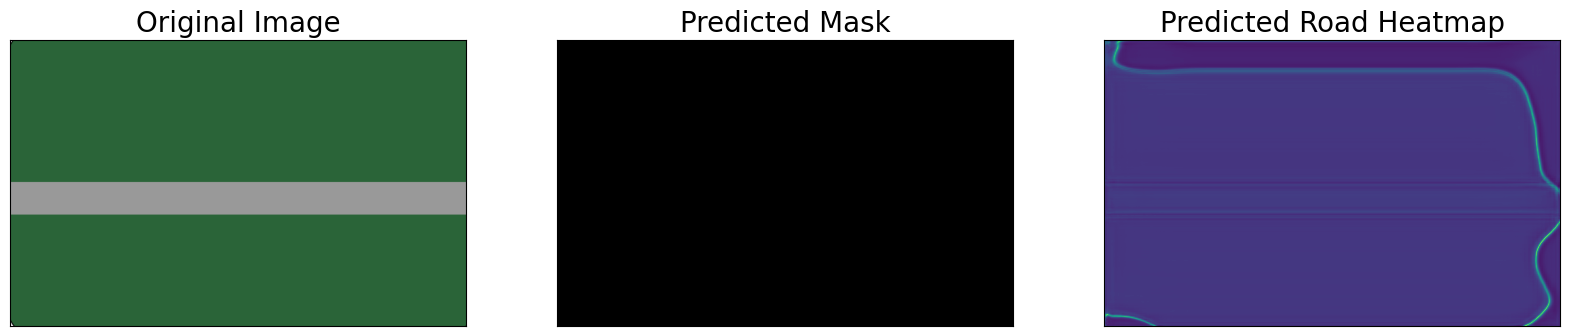

In [80]:
img_path = 'u1.png'  # Replace with the path to your image
pred_mask, pred_road_heatmap = predict_and_visualize_from_path(img_path, best_model, DEVICE, select_classes, class_rgb_values, get_preprocessing(preprocessing_fn))


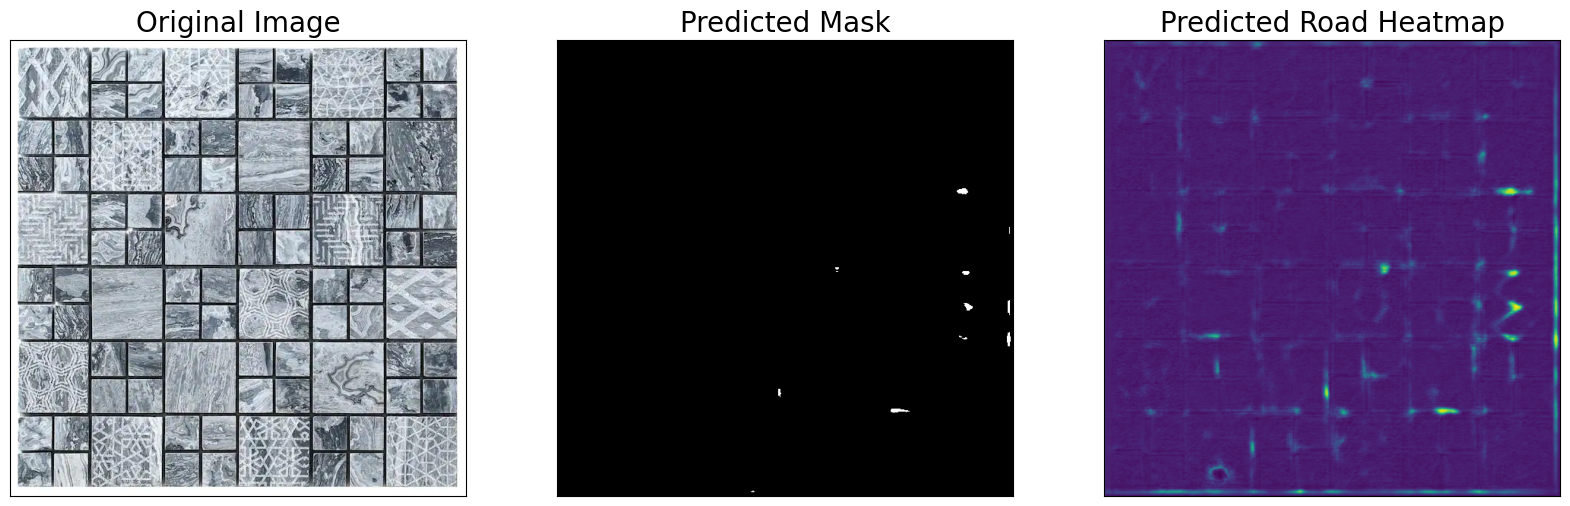

In [81]:
img_path = 'd1.webp'  # Replace with the path to your image
pred_mask, pred_road_heatmap = predict_and_visualize_from_path(img_path, best_model, DEVICE, select_classes, class_rgb_values, get_preprocessing(preprocessing_fn))
